In [1]:
import numpy as np
import copy
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
import torch
import torch.nn as nn
import dtnnlib as dtnn
# import resnet_cifar

In [3]:
import scipy.stats as st

## Image Dot Product

In [4]:
N = 5
W = np.ones((N,N))

In [5]:
def gkern(kernlen=21, nsig=3):
    """Returns a 2D Gaussian kernel."""

    x = np.linspace(-nsig, nsig, kernlen+1)
    kern1d = np.diff(st.norm.cdf(x))
    kern2d = np.outer(kern1d, kern1d)
    return kern2d/kern2d.sum()

In [6]:
G = gkern(N, 2.5)
G = G/G.max()

In [7]:
G

array([[0.02504279, 0.09989847, 0.15824913, 0.09989847, 0.02504279],
       [0.09989847, 0.39850617, 0.63127345, 0.39850617, 0.09989847],
       [0.15824913, 0.63127345, 1.        , 0.63127345, 0.15824913],
       [0.09989847, 0.39850617, 0.63127345, 0.39850617, 0.09989847],
       [0.02504279, 0.09989847, 0.15824913, 0.09989847, 0.02504279]])

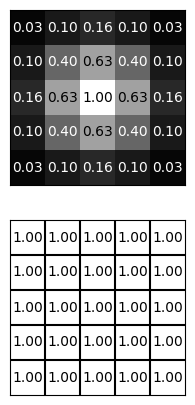

In [8]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(3, 5))
ax = ax0
ax.imshow(G, vmin=0, vmax=1, cmap="gray")
for i in range(G.shape[0]):
    for j in range(G.shape[1]):
        v = float(G[i, j])
        text = ax.text(j, i, f"{v:.2f}",
                       ha="center", va="center", color=["white", "k"][v>0.5])
ax.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
# plt.show()

##############

# fig, ax = plt.subplots(1, 1, figsize=(3,2.5))
ax = ax1
ax.imshow(W, vmin=0, vmax=1, cmap="gray")
color = "orange"
for i in range(W.shape[0]):
    for j in range(W.shape[1]):
        v = float(W[i, j])
        text = ax.text(j, i, f"{v:.2f}",
                       ha="center", va="center", color=["white", "k"][v>0.5])
    if i >= W.shape[0]-1:
        continue
    ax.hlines(i+0.5, -0.5, N-0.5, color="k")
    ax.vlines(i+0.5, -0.5, N-0.5, color="k")
#         ax.hlines(i-0.5, -0.5, 4.5, color="k")
#         ax.vlines(i-0.5, -0.5, 4.5, color="k")
    pass

plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)

# plt.show()

In [9]:
alphas = np.linspace(0, 1, num=10)

## For dot products

In [10]:
### From zeros to G
dot_prods0 = []
for alpha in alphas:
    A = alpha*G #+ (1-alpha)*W
    dp = (A*G).sum() ### calculating the dot product
#     dp = dp/np.linalg.norm(A)
    dot_prods0.append(dp)

In [11]:
dot_prods0

[0.0,
 0.37908563424140523,
 0.7581712684828105,
 1.1372569027242156,
 1.516342536965621,
 1.8954281712070262,
 2.2745138054484313,
 2.6535994396898364,
 3.032685073931242,
 3.4117707081726465]

In [12]:
### From G to ones
dot_prods1 = []
for alpha in alphas:
    A = alpha*W + (1-alpha)*G
    dp = (A*G).sum() ### calculating the dot product    
#     dp = dp/np.linalg.norm(A)
    dot_prods1.append(dp)

In [13]:
dot_prods1

[3.4117707081726465,
 3.771737735440785,
 4.131704762708924,
 4.491671789977063,
 4.851638817245202,
 5.21160584451334,
 5.571572871781479,
 5.931539899049617,
 6.291506926317756,
 6.651473953585895]

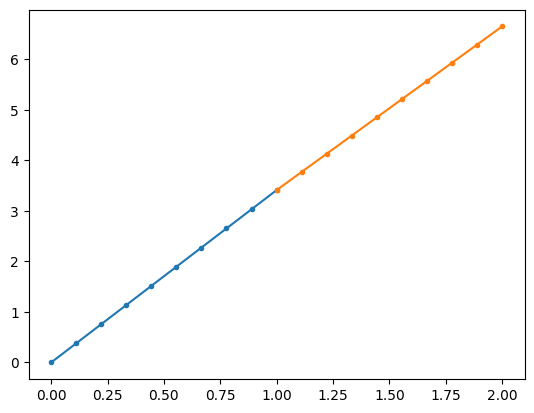

In [14]:
plt.plot(alphas, dot_prods0, marker='.')
plt.plot(alphas+1, dot_prods1, marker='.')

In [15]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.ticker import FormatStrFormatter

In [16]:
! mkdir outputs/03.0_image_dot_product

mkdir: cannot create directory ‘outputs/03.0_image_dot_product’: File exists


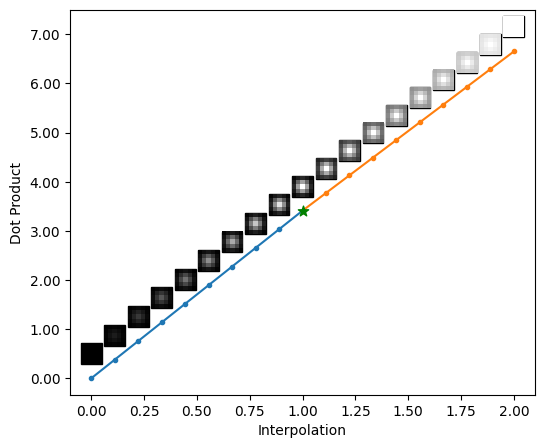

In [17]:
## Plot the output with images

fig, ax = plt.subplots(1, 1, figsize=(6,5))

plt.plot(alphas, dot_prods0, marker='.')
plt.plot(alphas+1, dot_prods1, marker='.')

for idx_alpha, alpha in enumerate(alphas):
    if idx_alpha+1 == len(alphas):
        continue
    A = alpha*G #+ (1-alpha)*W
    dp = (A*G).sum() ### calculating the dot product
    
    im = OffsetImage(A, norm=matplotlib.colors.Normalize(vmin=0, vmax=1), cmap="gray", zoom=3)
    ab = AnnotationBbox(im, (alpha, dp+0.5), frameon=True, pad=0)
    ax.add_artist(ab)
    
for alpha in alphas:
    A = alpha*W + (1-alpha)*G
#     print(A)
    dp = (A*G).sum() ### calculating the dot product    
    im = OffsetImage(A, norm=matplotlib.colors.Normalize(vmin=0, vmax=1), cmap="gray", zoom=3)
    ab = AnnotationBbox(im, (1+alpha, dp+0.5), frameon=True, pad=0)
    ax.add_artist(ab)

ax.scatter(alphas[-1], dot_prods0[-1], marker='*', s=60, color='green', zorder=20)

ax.set_ylim(top=7.5)
ax.set_xlabel("Interpolation")
ax.set_ylabel("Dot Product")
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
# plt.show()
# plt.tick_params(left = False, right = False , labelleft = False ,
#                 labelbottom = False, bottom = False)
plt.savefig("./outputs/03.0_image_dot_product/interpolate_image_dot.pdf", bbox_inches='tight')

## For euclidean distance

In [18]:
### From zeros to G
dists0 = []
for alpha in alphas:
    A = alpha*G #+ (1-alpha)*W
    d = np.linalg.norm((A-G).reshape(-1), ord=2)  ### calculating the euclidean_distance
    dists0.append(d)

### From G to ones
dists1 = []
for alpha in alphas:
    A = alpha*W + (1-alpha)*G
    d = np.linalg.norm((A-G).reshape(-1), ord=2)  ### calculating the euclidean_distance
    dists1.append(d)

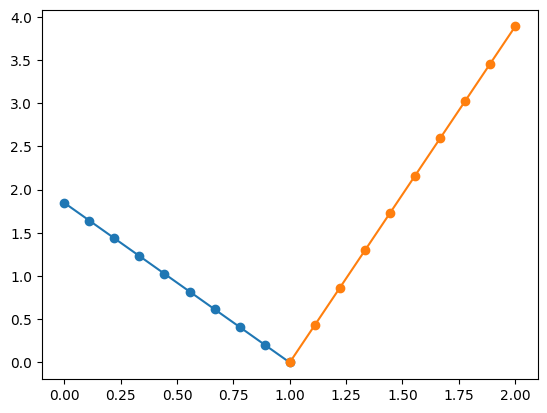

In [19]:
plt.plot(alphas, dists0, marker='o')
plt.plot(alphas+1, dists1, marker='o')

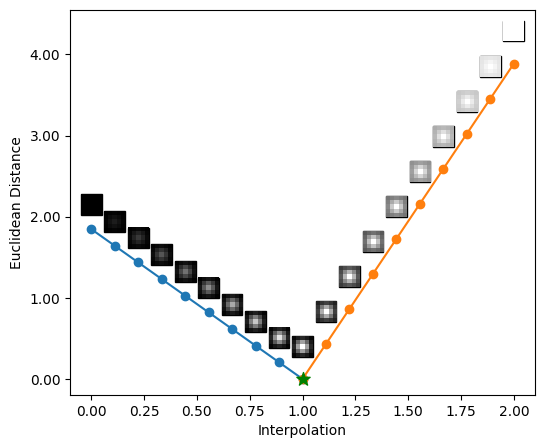

In [20]:
## Plot the output with images

fig, ax = plt.subplots(1, 1, figsize=(6,5))

plt.plot(alphas, dists0, marker='o')
plt.plot(alphas+1, dists1, marker='o')

for idx_alpha, alpha in enumerate(alphas):
    if idx_alpha+1 == len(alphas):
        continue
    A = alpha*G #+ (1-alpha)*W
    d = np.linalg.norm((A-G).reshape(-1), ord=2)  ### calculating the euclidean_distance
    
    im = OffsetImage(A, norm=matplotlib.colors.Normalize(vmin=0, vmax=1), cmap="gray", zoom=3)
    ab = AnnotationBbox(im, (alpha, d+0.3), frameon=True, pad=0)
    ax.add_artist(ab)
    
for alpha in alphas:
    A = alpha*W + (1-alpha)*G
    d = np.linalg.norm((A-G).reshape(-1), ord=2)  ### calculating the euclidean_distance
    im = OffsetImage(A, norm=matplotlib.colors.Normalize(vmin=0, vmax=1), cmap="gray", zoom=3)
    ab = AnnotationBbox(im, (1+alpha, d+0.4), frameon=True, pad=0)
    ax.add_artist(ab)

ax.scatter(alphas[-1], dists0[-1], marker='*', s=100, color='green', zorder=20)
ax.set_ylim(top=4.55)
ax.set_xlabel("Interpolation")
ax.set_ylabel("Euclidean Distance")
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
# plt.show()
# plt.tick_params(left = False, right = False , labelleft = False ,
#                 labelbottom = False, bottom = False)
plt.savefig("./outputs/03.0_image_dot_product/interpolate_image_distance.pdf", bbox_inches='tight')

## For angle / cos(theta)

In [21]:
### From zeros to G
dists0 = []
for alpha in alphas:
    A = alpha*G #+ (1-alpha)*W
    u, v = A.reshape(-1), G.reshape(-1)
    d = np.dot(u,v)/(np.linalg.norm(u)*np.linalg.norm(v)) ## calculating cosine angle
#     d = np.dot(u,v)/np.linalg.norm(u)/np.linalg.norm(v) ## calculating cosine angle
    if alpha == 0:
        d = 1
    d = np.clip(d, -1, 1)
    dists0.append(d)

### From G to ones
dists1 = []
for alpha in alphas:
    A = alpha*W + (1-alpha)*G
    u, v = A.reshape(-1), G.reshape(-1)
    d = np.dot(u,v)/(np.linalg.norm(u)*np.linalg.norm(v)+1e-15) ## calculating cosine angle
    d = np.clip(d, -1, 1)
    dists1.append(d)

/tmp/ipykernel_1462260/3773052418.py:6: RuntimeWarning: invalid value encountered in double_scalars
  d = np.dot(u,v)/(np.linalg.norm(u)*np.linalg.norm(v)) ## calculating cosine angle


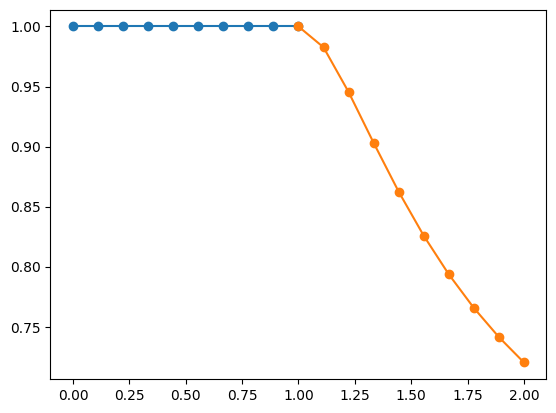

In [22]:
plt.plot(alphas, dists0, marker='o')
plt.plot(alphas+1, dists1, marker='o')

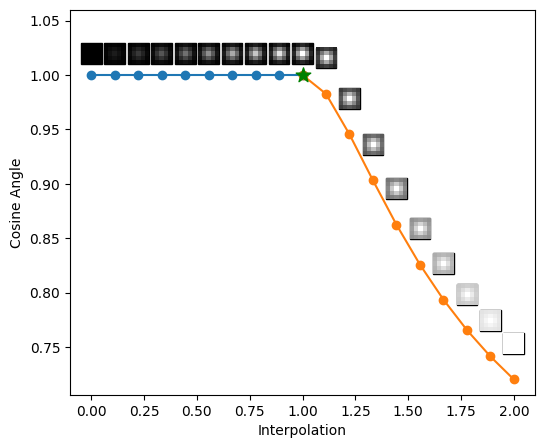

In [23]:
## Plot the output with images

fig, ax = plt.subplots(1, 1, figsize=(6,5))

for idx_alpha, alpha in enumerate(alphas):
    A = alpha*G #+ (1-alpha)*W
    d = dists0[idx_alpha]
    im = OffsetImage(A, norm=matplotlib.colors.Normalize(vmin=0, vmax=1), cmap="gray", zoom=3)
    ab = AnnotationBbox(im, (alpha, d+0.02), frameon=True, pad=0)
    ax.add_artist(ab)
    
for idx_alpha, alpha in enumerate(alphas):
    if idx_alpha == 0:
        continue
    A = alpha*W + (1-alpha)*G
    d = dists1[idx_alpha]
    im = OffsetImage(A, norm=matplotlib.colors.Normalize(vmin=0, vmax=1), cmap="gray", zoom=3)
    ab = AnnotationBbox(im, (1+alpha, d+0.033), frameon=True, pad=0)
    ax.add_artist(ab)

ax.scatter(alphas[-1], dists0[-1], marker='*', s=120, color='green', zorder=20)

plt.plot(alphas, dists0, marker='o')
plt.plot(alphas+1, dists1, marker='o')

ax.set_ylim(top=1.06)
ax.set_xlabel("Interpolation")
ax.set_ylabel("Cosine Angle")
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

# plt.show()
# plt.tick_params(left = False, right = False , labelleft = False ,
#                 labelbottom = False, bottom = False)
plt.savefig("./outputs/03.0_image_dot_product/interpolate_image_angle.pdf", bbox_inches='tight')

## For 2D vector, compare dot product to distance

In [75]:
a = np.array([1, 0.1])
b = np.array([
    [1.1, 0.2],
    [1.1, 0.9]
])

In [76]:
a@b.T

array([1.12, 1.19])

In [132]:
### slope of a:
# _m = a[1]/a[0]
### slope of perpendicular line
# _tm = -1/_m
_tm = -a[0]/a[1]
### equation of line passing through point(a) and slope _tm
x = np.array([0.8, 1.1])
_y = _tm*(x-a[0])+a[1]
_y

array([ 2.1, -0.9])

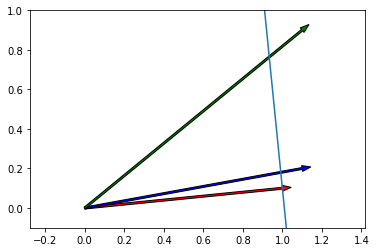

In [139]:
plt.arrow(0, 0, a[0], a[1], width=0.01, facecolor='r')
plt.arrow(0, 0, b[0,0], b[0,1], width=0.01, facecolor='b')
plt.arrow(0, 0, b[1,0], b[1,1], width=0.01, facecolor='g')

plt.plot(x, _y)

plt.axis('equal')
# plt.xlim(-0.1, 1.4)
plt.ylim(-0.1, 1.0)

plt.show()